In [1]:
import numpy as np
import json
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)
from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.preprocess.utils import overlay, enhance_contrast, normalize_img_to_uint8
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


## Convert Labelme Json to COCO Json

run the following code once for generating coco json
```
import livecell_tracker.segment
import livecell_tracker.annotation
import livecell_tracker.annotation.labelme2coco
import os
labelme_json_folder = r"""../datasets/a549_ccnn/annotation_data"""
dataset_folder_path = r"""../datasets/a549_ccnn/original_data"""
export_dir = "./notebook_results/correction_cnn_v0.0.0/"
os.makedirs(export_dir, exist_ok=True)
livecell_tracker.annotation.labelme2coco.convert(
    labelme_json_folder,
    export_dir,
    train_split_rate=0.9,
    dataset_folder_path=dataset_folder_path,
    # is_image_in_json_folder=True,
    image_file_ext="tif",
    # image_file_ext="png",
)
```

## Load COCO into SingleCell Objects

In [2]:
from pycocotools.coco import COCO

coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/train.json")

coco_data.anns.keys(), coco_data.anns[1].keys(), coco_data.anns[1]["segmentation"][0][
    :5
]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [3]:
coco_data.imgs.keys(), coco_data.imgs[1].keys(), coco_data.imgs[1]["file_name"],


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 dict_keys(['height', 'width', 'id', 'file_name']),
 '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile7_DIC-FITC.tif')

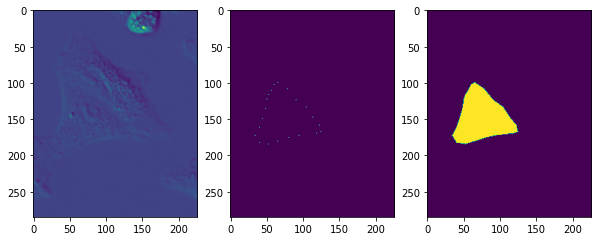

In [4]:
from typing import List

from livecell_tracker.annotation.coco_utils import coco_to_sc

single_cells = coco_to_sc(coco_data)


# for testing
single_cells = single_cells[:20]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
cell_id = 10
axes[0].imshow(single_cells[cell_id].get_img_crop(padding=100))
axes[1].imshow(single_cells[cell_id].get_contour_mask_closed_form(padding=100))
axes[2].imshow(single_cells[cell_id].get_contour_mask(padding=100))


save a list of single cell objects

In [5]:
SingleCellStatic.write_single_cells_json(
    single_cells, "../datasets/a549_ccnn/single_cells.json"
)


In [6]:
contour_mask = single_cells[cell_id].get_contour_mask(padding=100)
contour_mask.astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

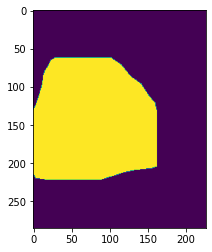

In [7]:
import cv2 as cv
from livecell_tracker.preprocess.utils import dilate_or_erode_mask

plt.imshow(dilate_or_erode_mask(contour_mask.astype(np.uint8), 1))

## Compute similarity between manually segmented cell and segmentation results

We will take sample_sc as an example to show how to compute IOU based similarity between manually segmented cell and segmentation results from machine learning models.  
Instead, this part may be done by a human annotator by clicking the corresponding cell in the segmentation results.

In [8]:
sample_sc = single_cells[cell_id]
sample_sc.meta

{'img_id': 7,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile8_DIC-FITC.tif'}

In [9]:
import glob
raw_img_dataset = sample_sc.img_dataset
seg_data_dir = "../datasets/a549_ccnn/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11"
seg_paths = glob.glob(os.path.join(seg_data_dir, "*.png"))
print(seg_paths[:2])
matched_time2seg = {}
# for time, img_path in raw_img_dataset.time2url.items():
#     substr = os.path.basename(img_path).split(".")[0]
#     print("substr:", substr)
#     for seg_path
#     break
corrected_indices = []
for seg_path in seg_paths:
    substr = os.path.basename(seg_path).split(".")[0]
    substr = substr[4:] # get rid of seg_ prefix
    img, path, index = raw_img_dataset.get_img_by_url(substr, return_path_and_time=True, ignore_missing=True)
    if path is None:
        print("skip due to substr not found:", substr)
        continue
    matched_time2seg[index] = seg_path

seg_data = LiveCellImageDataset(time2url=matched_time2seg, ext="png")
sample_sc.mask_dataset = seg_data
assert len(seg_data) == len(raw_img_dataset)

['../datasets/a549_ccnn/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11\\seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile1_DIC-FITC.png', '../datasets/a549_ccnn/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11\\seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile2_DIC-FITC.png']
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile2_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY2_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24

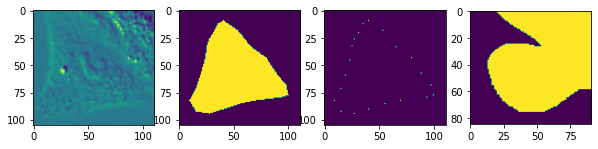

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes[0].imshow(sample_sc.get_img_crop(padding=10))
axes[1].imshow(sample_sc.get_contour_mask(padding=10))
axes[2].imshow(sample_sc.get_contour_mask_closed_form(padding=10))
axes[3].imshow(sample_sc.get_mask_crop())

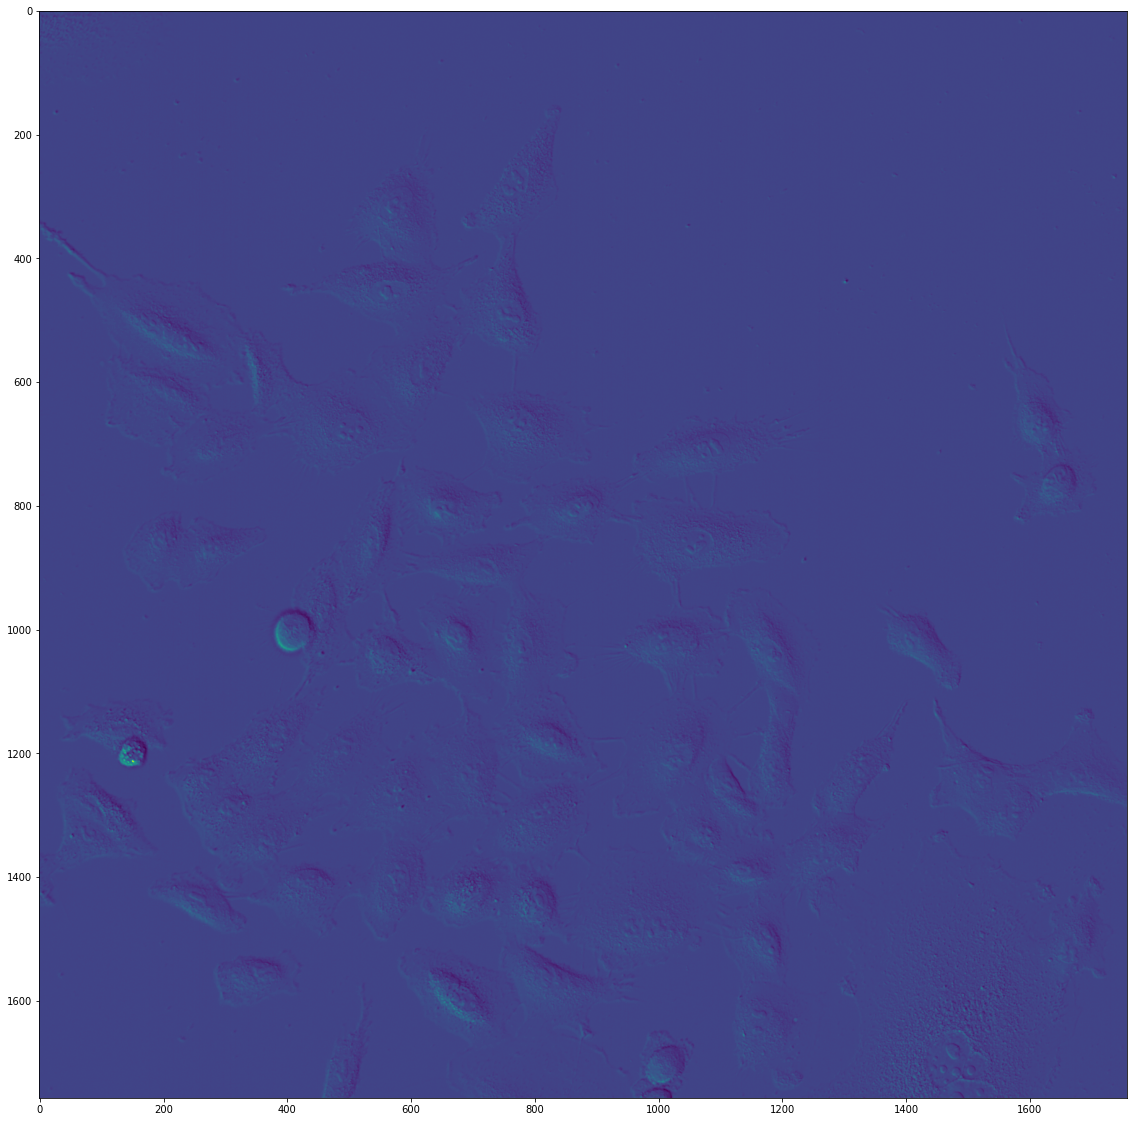

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(sample_sc.get_img())

In [12]:
seg_mask = seg_data.get_img_by_url(os.path.basename(sample_sc.meta["path"]).split(".")[0], substr=True)

In [13]:
np.max(seg_mask.flatten())

59

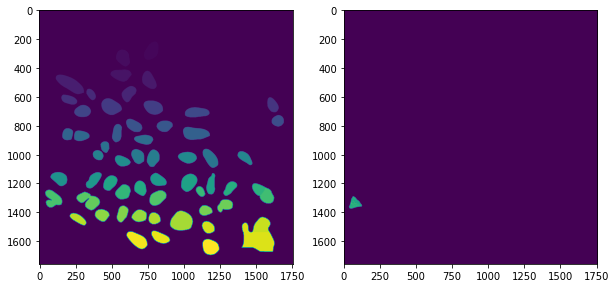

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(seg_mask)
axes[1].imshow(sample_sc.get_contour_img(crop=False))

Text(0.5, 1.0, 'ground truth')

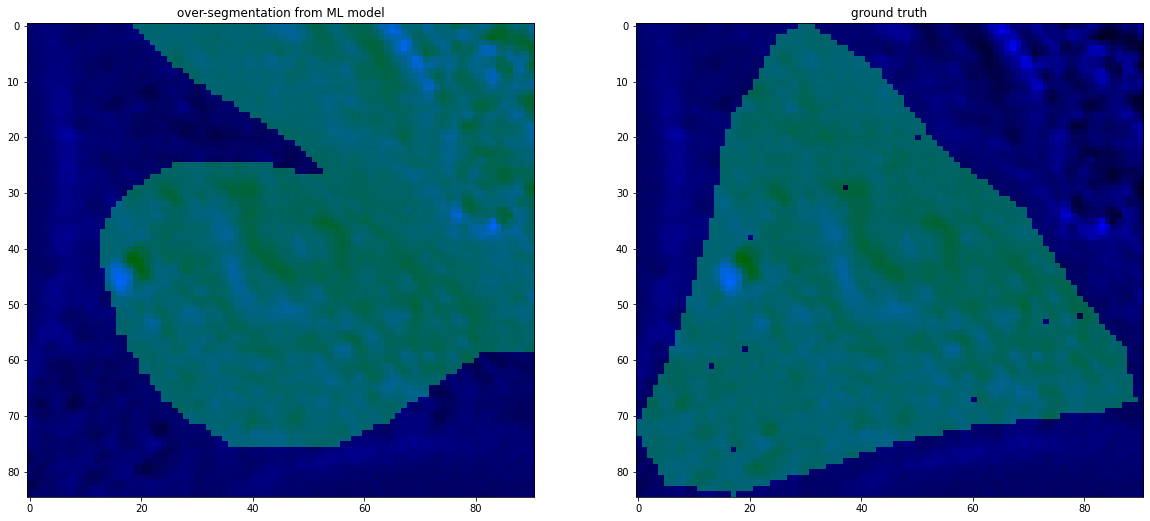

In [15]:
cropped_seg_mask = SingleCellStatic.gen_skimage_bbox_img_crop(sample_sc.bbox, seg_mask)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(overlay(sample_sc.get_img_crop(), cropped_seg_mask, img_channel_rgb_val_factor=1))
axes[0].set_title("over-segmentation from ML model")
axes[1].imshow(overlay(sample_sc.get_img_crop(), sample_sc.get_contour_img(), img_channel_rgb_val_factor=1))
axes[1].set_title("ground truth")

In [16]:
from livecell_tracker.segment.utils import match_mask_labels_by_iou
match_mask_labels_by_iou(cropped_seg_mask, sample_sc.get_contour_mask())

{True: {'best_iou': 0.49030011606698726, 'seg_label': 42}}

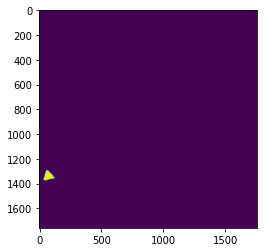

In [17]:
plt.imshow(sample_sc.get_contour_mask(crop=False))

Text(0.5, 1.0, 'T07 XY4 TILE7 seg overlay')

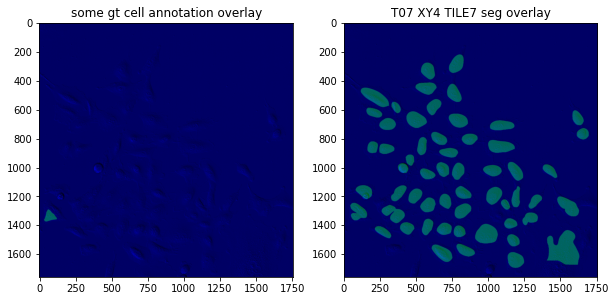

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(overlay(enhance_contrast(normalize_img_to_uint8(sample_sc.get_img())
, factor=0.5), sample_sc.get_contour_mask(crop=False), img_channel_rgb_val_factor=2))
axes[0].set_title("some gt cell annotation overlay")
axes[1].imshow(overlay(enhance_contrast(normalize_img_to_uint8(sample_sc.get_img()), factor=0.9), seg_mask, img_channel_rgb_val_factor=2))
axes[1].set_title("T07 XY4 TILE7 seg overlay")

In [19]:
sample_sc.get_contour_mask()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [20]:
def match_seg_mask_label(mask: np.array, sc: SingleCellStatic):
    """find a single cell's label in a mask. sc must contain its contour information."""
    cropped_seg_mask = SingleCellStatic.gen_skimage_bbox_img_crop(sc.bbox, seg_mask)
    match_res = match_mask_labels_by_iou(cropped_seg_mask, sc.get_contour_mask())
    assert (len(match_res) == 1), "TODO: bug in match_mask_labels_by_iou"
    match_res = list(match_res.values())[0]
    return match_res

seg_label = match_seg_mask_label(seg_mask, sample_sc)["seg_label"]
seg_label

42

### Compute similarity for all cells and get the mapping between single cells and its corresponding label in the segmentation results

In [21]:
for sc in tqdm(single_cells):
    sc_img_path_substr = os.path.basename(sc.meta["path"]).split(".")[0]
    seg_mask = seg_data.get_img_by_url(sc_img_path_substr, substr=True)
    sc.meta["seg_label"] = match_seg_mask_label(seg_mask, sc)["seg_label"]
    sc.mask_dataset = seg_data

100%|██████████| 20/20 [00:01<00:00, 14.10it/s]


<AxesSubplot:>

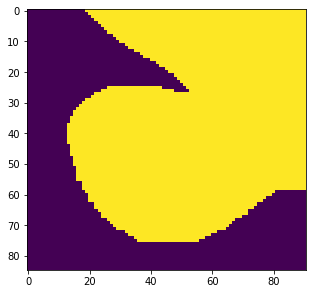

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sample_sc.show_mask()

## Generate dilated and eroded masks for each cell
Create an augmented dataset.
Save results via single cell data structure
```
Single Cell Json metadata
{
    is_augmented: True
    augment_method: "dilate" or "erode"
    augment_factor: 0.1
    kernel_size: len(actual_kernel_used) (gaussian)
}
```

We pad the each cell mask with a defined background value (0).

In [34]:
len(seg_data), len(sample_sc.img_dataset)

(59, 59)

100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


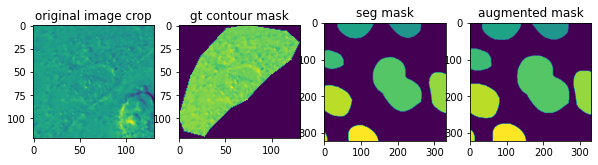

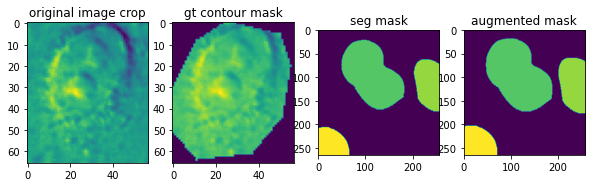

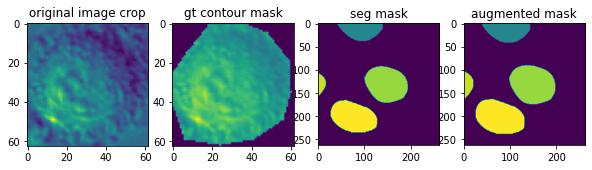

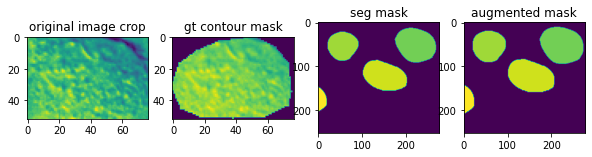

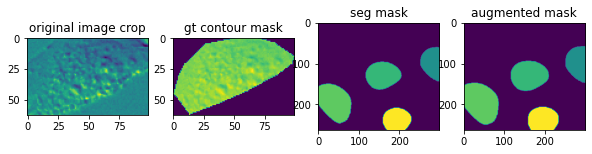

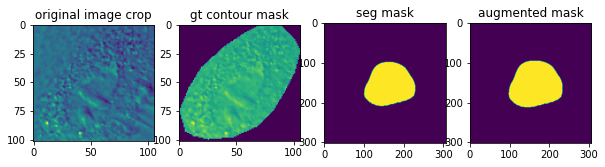

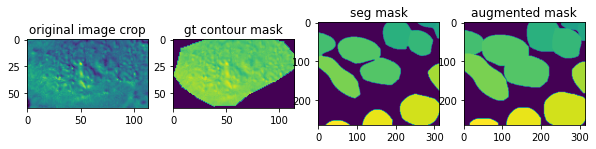

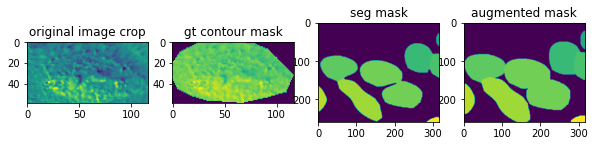

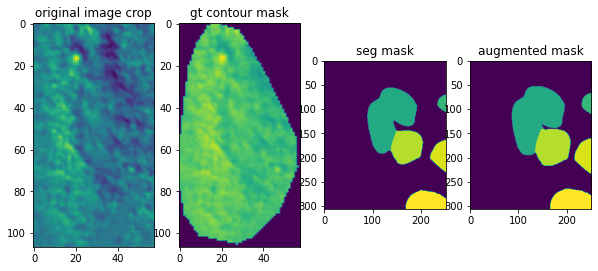

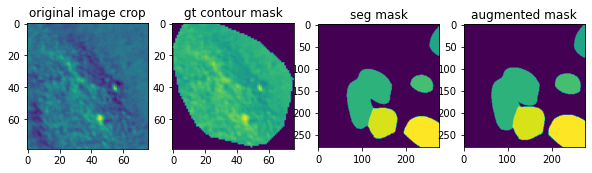

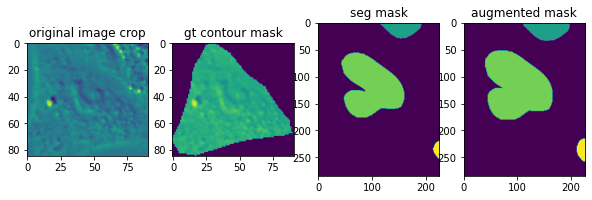

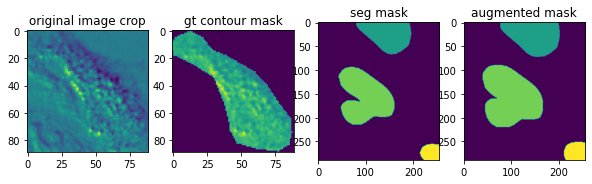

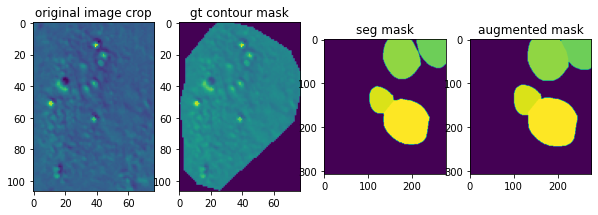

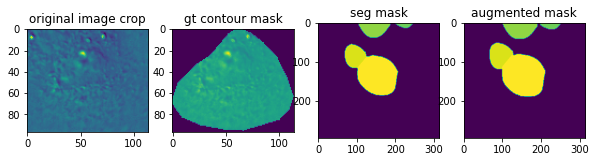

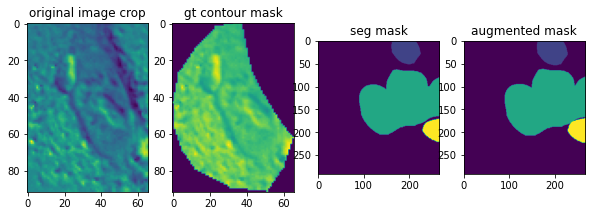

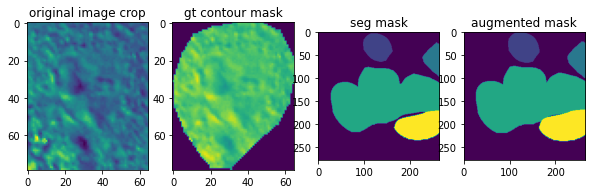

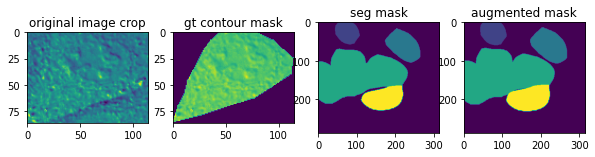

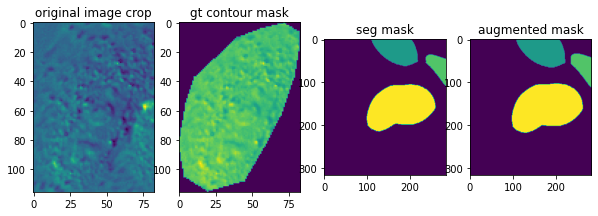

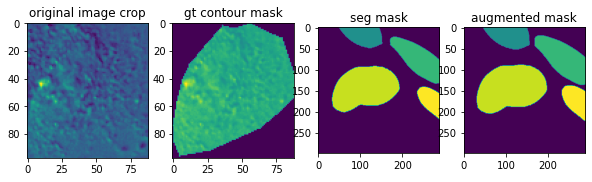

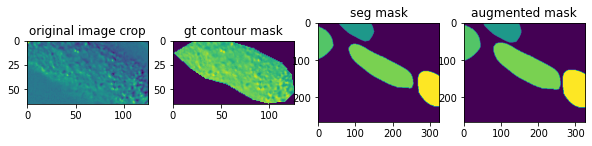

In [35]:
from pathlib import Path
from copy import deepcopy
from PIL import Image, ImageSequence

def save_png(img: np.array, path: str, mode="L"):
    """save image to png file

    Parameters
    ----------
    path : str
        path to save the image
    img : np.array
        image to save
    """
    img = img.astype(np.uint8)
    img = Image.fromarray(img, mode=mode)
    img.save(path)

img_paths = []
augment_dir = Path("../datasets/a549_ccnn/augmented_cells")
augmented_cells = []
scale_factor = 0.01
padding = 100

def augment_single_cell(sc: SingleCellStatic, augment_dir: Path, scale_factor=0.01, padding=40, show=False):
    mask = sc.get_mask_crop(padding=padding).astype(np.uint8)
    augmented_mask = dilate_or_erode_mask(mask, scale_factor=scale_factor)
    path = augment_dir / f"{i}_mask.png"
    save_png(augmented_mask, str(path))

    meta = {}
    meta["original_path"] = sc.meta["path"]
    meta["original_seg_label"] = sc.meta["seg_label"]
    meta["path"] = path.as_posix()
    meta["padding"] = padding
    meta["scale_factor"] = scale_factor
    meta["method"] = "dilate/erode"

    new_sc = SingleCellStatic(
        img_dataset=sc.img_dataset,
        mask_dataset=sc.mask_dataset,
        contour = np.array(sc.contour),
        meta=meta,
    )

    if show:
        fig, axes = plt.subplots(1, 4, figsize=(10, 10))
        # sc.show_mask(ax=axes[0])
        sc.show(ax=axes[0])
        axes[2].imshow(mask)
        sc.show_contour_img(ax=axes[1])
        axes[3].imshow(augmented_mask)

        axes[0].set_title("original image crop")
        axes[2].set_title("seg mask")
        axes[1].set_title("gt contour mask")
        axes[3].set_title("augmented mask")
    return new_sc


for i in tqdm(range(len(single_cells))):
    sc = single_cells[i]
    augment_single_cell(sc, augment_dir, scale_factor=scale_factor, padding=padding, show=True)

    